Part of https://github.com/htdt/cartpole-solved

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
!pip install -q gym ipdb

In [0]:
!wget -N -q -o - https://raw.githubusercontent.com/htdt/cartpole-solved/master/segment_tree.py

In [0]:
from collections import deque
import gym, random, math, ipdb
from tqdm import trange
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from segment_tree import SumDeque

gym.logger.set_level(40)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
class DQN(nn.Module):
  input_dim = 4
  output_dim = 2
  hidden = 32

  def __init__(self):
    super(DQN, self).__init__()
    self.features = nn.Sequential(
      nn.Linear(self.input_dim, self.hidden),
      nn.ReLU(),
      nn.Linear(self.hidden, self.hidden),
      nn.ReLU())
    self.adv = nn.Linear(self.hidden, self.output_dim)
    self.val = nn.Linear(self.hidden, 1)

  def forward(self, x):
    x = self.features(x)
    adv = self.adv(x)
    val = self.val(x)
    return val + adv - adv.mean(1, keepdim=True)

In [0]:
class Agent:
  output_dim = 2
  lr = 1e-3
  batch_size = 32
  gamma = 0.99

  def __init__(self):
    self.online_net = DQN()
    self.online_net.train()

    self.target_net = DQN()
    self.update_target_net()
    for param in self.target_net.parameters(): param.requires_grad = False

    self.optimiser = optim.Adam(self.online_net.parameters(), lr=self.lr)

  def act(self, state):
    state = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
      return self.online_net(state).argmax(1).item()

  def act_e_greedy(self, state, epsilon=0.01):
    if random.random() < epsilon:
      return random.randrange(self.output_dim)
    else:
      return self.act(state)

  def train_iter(self, buffer):
    state, action, reward, next_state, terminal, weights, idx = buffer.sample(self.batch_size)
       
    q_value = self.online_net(state)[range(self.batch_size), action]
    with torch.no_grad():
      next_state_action = self.online_net(next_state).max(1)[1] # online_net to get action for next_state
      next_qv = self.target_net(next_state)[range(self.batch_size), next_state_action] # target_net to get Q
      target_qv = reward + self.gamma * (1 - terminal) * next_qv
    
    loss = (q_value - target_qv).pow(2)
    #loss *= weights
    buffer.update_prior(idx, loss.tolist())

    self.optimiser.zero_grad()
    loss.mean().backward()
    self.optimiser.step()


  def update_target_net(self):
    self.target_net.load_state_dict(self.online_net.state_dict())

In [0]:
class ReplayBuffer():
  def __init__(self, capacity):
    self.capacity = capacity
    self._buffer = deque(maxlen=capacity)
    self._prior = SumDeque(capacity)
    self._prior.max = 1.
  
  def append(self, t):
    self._buffer.append(t)
    self._prior.append(self._prior.max)
    
  def sample(self, batch_size):
    idx = [self._prior.find_prefixsum_idx(random.random() * self._prior.sum()) for _ in range(batch_size)]
    weights = 1. / np.sqrt([self._prior[i] for i in idx]) # hardcoded beta = .5
    weights /= weights.max()
    tt = [self._buffer[i] for i in idx]
    s, a, r, ns, t = zip(*tt)
    f, l = torch.FloatTensor, torch.LongTensor
    return f(s), l(a), f(r), f(ns), f(t), f(weights), idx

  def update_prior(self, idxes, losses):
    for idx, loss in zip(idxes, losses):
      self._prior[idx] = np.sqrt(loss) # hardcoded alpha = .5

  def __len__(self):
    return len(self._buffer)

100%|██████████| 10000/10000 [01:29<00:00, 176.72it/s]


76.87257364057092


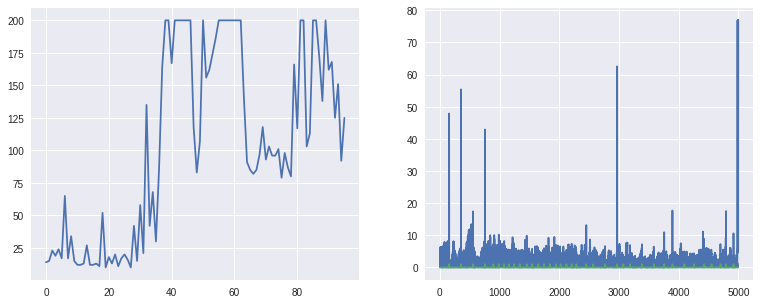

In [8]:
buffer = ReplayBuffer(5000)
env = gym.make("CartPole-v0")
agent = Agent()

rewards = []
episode_reward = 0
state = env.reset()

for i in trange(10000):
  eps = .01 + .99 * math.exp(-i / 500) # close to .01 at 3500
  action = agent.act_e_greedy(state, eps)
  next_state, reward, done, _ = env.step(action)
  buffer.append((state, action, reward, next_state, done))
  
  state = next_state
  episode_reward += reward
  
  if done:
    state = env.reset()
    rewards.append(episode_reward)
    episode_reward = 0
    
  if i > 100:
    agent.train_iter(buffer)
   
  if i > 100 and i % 100 == 0:
    agent.update_target_net()

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(rewards)
plt.subplot(132)
plt.plot(list(buffer._prior))
plt.plot(list(map(lambda t: int(t[-1]), buffer._buffer)))
print(buffer._prior.max)